In [ ]:
# Required packages

! pip install fiona # for reading and writing vector data
! pip install numpy # provides support for arrays, matrices, and many mathematical functions
! pip install pandas # for data analysis and manipulation
! pip install matplotlib # for interactive visualizations
! pip install seaborn # for interactive statistical visualizations
! pip install sklearn # for machine learning workflows
! pip install rasterio # for reading and writing geospatial raster data
! pip install geopandas # for spatial operations on geometric types
! pip install plotly # for interactive dynamics chart


In [5]:
# Loading required libraries

import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, accuracy_score

In [6]:
# Working with raster and vector (shapefile) GIS data

# Raster image of the study area
raster_file = 'data/image.TIF'

# Sample locations from which pixel values will be extracted from the raster.
points_file = 'data/sample_points.shp'

# An intermediate or modified version of sample_points.shp
temp_point_file = 'data/temp_points.shp'

# land cover names (for post visualization)
lulc_name = ['Water', 'Agriculture', 'Forest', 'Urban','Barren']

In [7]:
# Read and normalize the color bands of a raster image 
src = rio.open(raster_file)

blue = src.read(1, masked=True)
green = src.read(2, masked=True)
red = src.read(3, masked=True)

# This  takes a single-band array (e.g., red, green, or blue) and normalizes its values to a range between 0.0 and 1.0.
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands 
# The normalized bands (redn, greenn, bluen) can now be used in further analysis or combined to form a true-color composite
red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)


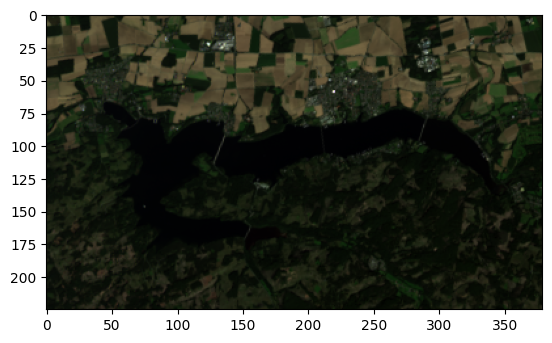

In [8]:
#  Combines the normalized red, green, and blue bands into an RGB composite image
rgb = np.dstack((red_n, green_n, blue_n))

plt.imshow(rgb)

Text(0.5, 1.0, 'Blue')

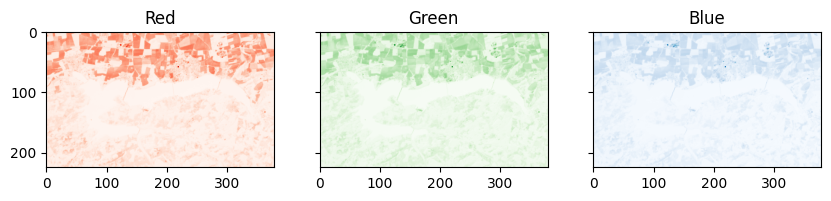

In [9]:
# Display each normalized band (Red, Green, and Blue)
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
ax1.imshow(red_n, cmap='Reds')
ax2.imshow(green_n, cmap='Greens')
ax3.imshow(blue_n, cmap='Blues')

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

In [10]:
# Prepares both the raster and vector data for further operations

#  reading bands from input
with rio.open(raster_file) as img:
    bands = (img.read()).shape[0]
print('Bands of input image: ', bands)

# using ilteration to automatically create a bands list
features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
f_len = len(features)

points = gpd.read_file(points_file)
# adding a new column 'id' with range of points
points = points.assign(id=range(len(points)))
# saving nenw point file with 'id'
points.to_file(temp_point_file) 
# Converts the points to a regular DataFrame (without geometry) for easier manipulation.
points_df = pd.DataFrame(points.drop(columns='geometry'))

Bands of input image:  3
Bands names:  ['band1', 'band2', 'band3']


In [11]:
# Extracts pixel values from a multi-band raster file at each point location specified in a shapefile, then organizes the sampled values into a pandas DataFrame

# ilterating over multiband raster
sampled = pd.Series()

# Opens the shapefile, extracts coordinates for each point, and samples raster pixel values at those points
with fiona.open(temp_point_file) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        with rio.open(raster_file) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas series accordingly
        sampled.loc[siteID] = value

# Stores sampled values in a series, reshapes it into a DataFrame, and expands bands into separate columns.
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(), 
                   columns=features)
df1['id'] = df1.index

# Merges sampled values with the original points’ attributes and prints the final DataFrame for analysis.
data = pd.merge(df1, points_df, on ='id')
print('Sampled Data: \n',data)

Sampled Data: 
      band1  band2  band3   id  Labels
0     7848   6735   6052    0       1
1     7810   6704   6026    1       1
2     7789   6689   5994    2       1
3     7799   6680   6007    3       1
4     7771   6661   5992    4       1
..     ...    ...    ...  ...     ...
120   8839   8404   8163  120       5
121   8374   7917   7455  121       5
122   8281   7793   7214  122       4
123   8259   7863   7193  123       5
124   8281   7868   7296  124       5

[125 rows x 5 columns]


In [15]:
# Prepares the data for training a machine learning model by separating it into features (independent variables) and labels (dependent variables), then splitting it into training and test sets

x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-1]
Y = y.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (87, 3)
X_test Shape: (38, 3)
y_train Shape: (87,)
y_test Shape:(38,)


### Support Vector Machine

In [16]:
# Trains a Support Vector Machine (SVM) model using the training data, makes predictions on the test data, and evaluates the model’s performance
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))

Accuracy SVM: 60.526315789473685
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.83      0.71      0.77         7
           3       0.50      1.00      0.67         8
           4       0.62      0.91      0.74        11
           5       0.00      0.00      0.00         6

    accuracy                           0.61        38
   macro avg       0.39      0.52      0.44        38
weighted avg       0.44      0.61      0.50        38



C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)
print(cm_percent)

import plotly.express as px

fig = px.imshow(cm_percent, text_auto=True, x=['Water', 'Agriculture', 'Forest', 'Urban','Barren'],y=['Water', 'Agriculture', 'Forest', 'Urban','Barren'])
fig.show()


Confusion Matrix RF: 
 [[ 0  0  6  0  0]
 [ 0  5  2  0  0]
 [ 0  0  8  0  0]
 [ 0  1  0 10  0]
 [ 0  0  0  6  0]]
[[0.         0.         0.15789474 0.         0.        ]
 [0.         0.13157895 0.05263158 0.         0.        ]
 [0.         0.         0.21052632 0.         0.        ]
 [0.         0.02631579 0.         0.26315789 0.        ]
 [0.         0.         0.         0.15789474 0.        ]]


In [18]:
# Applies a trained SVM classifier to an entire raster image, predicting land cover classes for each pixel and saving the classified raster as a new GeoTIFF file.

# Setting Up Filenames and Loading the Raster
#%%time
cName = 'SVM'
exp_name = f'results/lulc_{cName}.tif'

img = rio.open(raster_file)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')

# Reshaping Raster for Prediction
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)

# Extracting Raster Metadata
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

# Predicting Land Cover Classes for the Entire Image
pred_full = clf.predict(img_n)
print('Prediction Done')

# Reshaping Predictions to Raster Dimensions
img_reshape = pred_full.reshape(height, width)

# Exporting the Predicted Raster
out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}')

Height: 225
Width: 379
Bands: 3

reshaped full data shape  for prediction:  (85275, 3)
Prediction Done
Map saved SVM


### Random Forest

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Train the classifier
cName = 'RF'
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
clf_pred = clf.predict(X_test)

# Print accuracy and classification report
print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred) * 100:.2f}%")
print(classification_report(y_test, clf_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n', cm)

# Convert confusion matrix to row-wise percentage and ensure it's correct
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percent = np.nan_to_num(cm_percent)  # Replace any NaNs with 0 if they exist

# Print the percentage matrix for verification
print("Confusion Matrix as Percentages:\n", cm_percent)

# Plot conussion matrix
import plotly.express as px

fig = px.imshow(cm_percent, text_auto=True, x=['Water', 'Agriculture', 'Forest', 'Urban','Barren'],y=['Water', 'Agriculture', 'Forest', 'Urban','Barren'])
fig.show()



Accuracy RF: 86.84%
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       0.86      0.86      0.86         7
           3       0.89      1.00      0.94         8
           4       0.77      0.91      0.83        11
           5       1.00      0.50      0.67         6

    accuracy                           0.87        38
   macro avg       0.90      0.85      0.86        38
weighted avg       0.88      0.87      0.86        38

Confusion Matrix RF: 
 [[ 6  0  0  0  0]
 [ 0  6  1  0  0]
 [ 0  0  8  0  0]
 [ 0  1  0 10  0]
 [ 0  0  0  3  3]]
Confusion Matrix as Percentages:
 [[1.         0.         0.         0.         0.        ]
 [0.         0.85714286 0.14285714 0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.09090909 0.         0.90909091 0.        ]
 [0.         0.         0.         0.5        0.5       ]]


In [20]:
%%time

# Setting Up Variables and Loading the Raster File
cName = 'RF'
exp_name = f'results/lulc_{cName}.tif'
img = rio.open(raster_file)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')

# Reshaping Raster Data for Prediction
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)

# Running Predictions on the Entire Image
pred_full = clf.predict(img_n)
print('Prediction Done')

# Setting Metadata and Preparing the Output Raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

# Reshaping and Saving the Classified Raster
img_reshape = pred_full.reshape(height, width)
out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()
print(f'Map saved {cName}')

Height: 225
Width: 379
Bands: 3

reshaped full data shape  for prediction:  (85275, 3)
Prediction Done
Map saved RF
CPU times: total: 2.56 s
Wall time: 3.88 s


### Decision Tree

In [21]:
%%time

# Initializing and Training the Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

cName = 'DT'
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Making Predictions and Evaluating the Model
clf_pred = clf.predict(X_test)
print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))

# Calculating and Printing the Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

# Visualizing the Confusion Matrix
import plotly.express as px
fig = px.imshow(cm_percent, text_auto=True, x=['Water', 'Agriculture', 'Forest', 'Urban','Barren'],y=['Water', 'Agriculture', 'Forest', 'Urban','Barren'])
fig.show()

Accuracy DT: 81.57894736842105
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       0.86      0.86      0.86         7
           3       0.89      1.00      0.94         8
           4       0.78      0.64      0.70        11
           5       0.57      0.67      0.62         6

    accuracy                           0.82        38
   macro avg       0.82      0.83      0.82        38
weighted avg       0.82      0.82      0.81        38

Confusion Matrix RF: 
 [[6 0 0 0 0]
 [0 6 1 0 0]
 [0 0 8 0 0]
 [0 1 0 7 3]
 [0 0 0 2 4]]


CPU times: total: 188 ms
Wall time: 215 ms


In [22]:
%%time

# Setting Variables and Loading the Raster
cName = 'DT'
exp_name = f'results/lulc_{cName}.tif'
img = rio.open(raster_file)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')

# Reshaping Raster Data for Prediction
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)

# Running Predictions on the Entire Raster
pred_full = clf.predict(img_n)
print('Prediction Done, now exporting raster')

# Setting Metadata and Preparing for Output
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

# Reshaping Predictions and Saving the Output Raster
img_reshape = pred_full.reshape(height, width)

# Creating and Writing the Classified Raster File
out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

# Writing Data and Finalizing the Raster
out_raster.write(img_reshape, 1)
out_raster.close()
print(f'Map saved {cName}')

Height: 225
Width: 379
Bands: 3

reshaped full data shape  for prediction:  (85275, 3)
Prediction Done, now exporting raster
Map saved DT
CPU times: total: 719 ms
Wall time: 2.11 s
